# Topic Models

In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('wine_reviews_small.xlsx', index_col=0)
len(df)

20000

In [3]:
df.head()

,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_cleaned
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hail be age year oak ...
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aroma fig blackberry cassis be soften swe...
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,honor memory wine once make his mother tremend...
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spend month new french oak incorporate fruit v...
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,be top wine name high point vineyard foot have...


In [4]:
print(df.iloc[0].description)
print('-'*10)
print(df.iloc[0].description_cleaned)

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.
----------
tremendous varietal wine hail be age year oak red cherry fruit compelling hint caramel greet palate frame elegant fine tannin subtle minty tone background balanced rewarding start finish have year ahead develop further nuance enjoy


Here is how the data was cleaned

In [5]:
# import spacy
# nlp = spacy.load('en')
# def clean(text):
#     return ' '.join([token.lemma_ 
#             for token in nlp(text) 
#             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])

In [6]:
# remove empty entries
df = df[df['description_cleaned'].notnull()]
len(df)

19999

## LDA

In [10]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [11]:
limit=50000

# get dictionary
df['description_cleaned'] = df.description_cleaned.apply(str)
# run on 50000 instances
instances = df.description_cleaned.apply(str.split)[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(1124 unique tokens: ['age', 'background', 'balanced', 'caramel', 'cherry']...)


In [12]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [13]:
i = 10
print(df.description.iloc[i])
print(instances[i])
print(ldacorpus[i]) 
print(model_corpus[i])

Elegance, complexity and structure come together in this drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens with sublime yellow spring flower, aromatic herb and orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear and citrus flavors while white almond and savory mineral notes grace the lingering finish.
['elegance', 'complexity', 'structure', 'come', 'together', 'drop', 'dead', 'gorgeous', 'rank', 'great', 'white', 'open', 'sublime', 'yellow', 'spring', 'flower', 'aromatic', 'herb', 'orchard', 'fruit', 'scent', 'creamy', 'delicious', 'palate', 'seamlessly', 'combine', 'juicy', 'white', 'peach', 'ripe', 'pear', 'citrus', 'flavor', 'white', 'almond', 'savory', 'mineral', 'note', 'grace', 'linger', 'finish']
[(40, 1), (49, 1), (58, 1), (63, 3), (64, 1), (93, 1), (104, 1), (117, 1), (136, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), 

In [43]:
list(dictionary.items())

[(0, 'age'),
 (1, 'background'),
 (2, 'balanced'),
 (3, 'caramel'),
 (4, 'cherry'),
 (5, 'compelling'),
 (6, 'develop'),
 (7, 'elegant'),
 (8, 'enjoy'),
 (9, 'fine'),
 (10, 'frame'),
 (11, 'further'),
 (12, 'have'),
 (13, 'hint'),
 (14, 'minty'),
 (15, 'nuance'),
 (16, 'oak'),
 (17, 'red'),
 (18, 'start'),
 (19, 'subtle'),
 (20, 'tannin'),
 (21, 'tone'),
 (22, 'varietal'),
 (23, 'year'),
 (24, 'aroma'),
 (25, 'bake'),
 (26, 'balance'),
 (27, 'black'),
 (28, 'blackberry'),
 (29, 'cassis'),
 (30, 'chocolate'),
 (31, 'chocolaty'),
 (32, 'drink'),
 (33, 'fig'),
 (34, 'full'),
 (35, 'heady'),
 (36, 'intense'),
 (37, 'layered'),
 (38, 'oaky'),
 (39, 'rich'),
 (40, 'ripe'),
 (41, 'soften'),
 (42, 'spice'),
 (43, 'toasty'),
 (44, 'vanilla'),
 (45, 'color'),
 (46, 'complex'),
 (47, 'compote'),
 (48, 'dark'),
 (49, 'delicious'),
 (50, 'gold'),
 (51, 'hazelnut'),
 (52, 'his'),
 (53, 'its'),
 (54, 'layer'),
 (55, 'make'),
 (56, 'once'),
 (57, 'orange'),
 (58, 'pear'),
 (59, 'peel'),
 (60, 'residua

## Choosing the number of topics

In [45]:
coherence_values = []

dev_size = 10000
eval_size = 5000

for num_topics in range(5, 16):
    print(num_topics)
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5
5 -2.0617545619908753 0.31125205909931103
6
6 -2.1396158585588183 0.3379283527194577
7
7 -1.9630484009638358 0.32884210338875725
8
8 -2.105592889458976 0.30039581188425846
9
9 -2.1034338275053015 0.30525914013348737
10
10 -2.0962870564704437 0.32361794511041064
11
11 -2.544571194288309 0.34026927067598084
12
12 -2.5328495823451913 0.3630550224243326
13
13 -2.9992964086653418 0.3601224016680714
14
14 -2.2146248894110716 0.3055363830657147
15
15 -2.387025576773138 0.30959753189874967


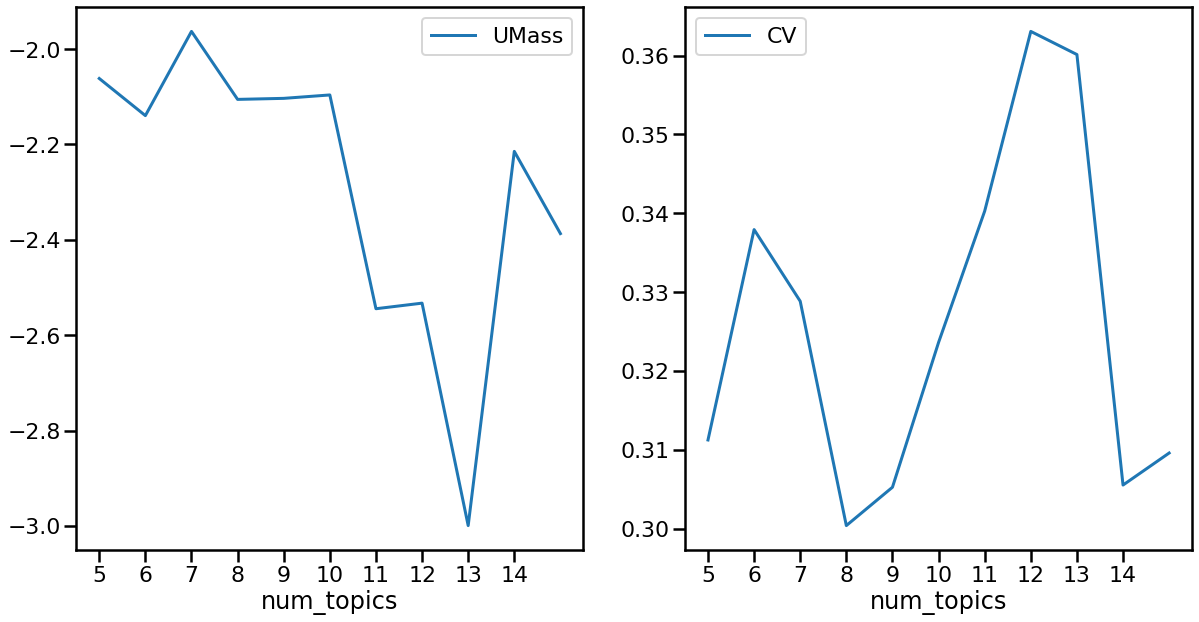

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,15));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,15));


In [52]:
num_topics = 6

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5
                    )
    
print("done in {}".format(time.time()-start), flush=True)


999.95
fitting model
done in 133.3698480129242


In [53]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.07786218),
 (1, 0.08116583),
 (2, 0.26942453),
 (3, 0.18731259),
 (4, 0.14873922),
 (5, 0.2354957)]

In [54]:
model.print_topics()

[(0,
  '0.019*"pear" + 0.019*"citrus" + 0.019*"clean" + 0.019*"apple" + 0.018*"peach" + 0.017*"white" + 0.014*"pineapple" + 0.013*"lemon" + 0.013*"melon" + 0.012*"orange"'),
 (1,
  '0.022*"acidity" + 0.020*"have" + 0.017*"ripe" + 0.017*"drink" + 0.017*"fruity" + 0.016*"soft" + 0.016*"now" + 0.016*"very" + 0.015*"texture" + 0.015*"rich"'),
 (2,
  '0.012*"its" + 0.012*"alcohol" + 0.011*"cassis" + 0.011*"beef" + 0.011*"pure" + 0.010*"price" + 0.009*"cola" + 0.009*"cherry" + 0.009*"layer" + 0.009*"deep"'),
 (3,
  '0.021*"expression" + 0.020*"tobacco" + 0.019*"clove" + 0.019*"open" + 0.018*"cherry" + 0.018*"leather" + 0.017*"black" + 0.016*"spice" + 0.015*"pepper" + 0.013*"tone"'),
 (4,
  '0.016*"feel" + 0.016*"plum" + 0.015*"jammy" + 0.015*"sweet" + 0.014*"blackberry" + 0.014*"earthy" + 0.013*"berry" + 0.013*"oak" + 0.013*"bit" + 0.013*"taste"'),
 (5,
  '0.024*"year" + 0.022*"age" + 0.017*"dark" + 0.016*"power" + 0.016*"wood" + 0.015*"more" + 0.015*"structure" + 0.014*"tannin" + 0.013*"sho

In [55]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=10)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:10]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "pear", "citrus", "clean", "apple", "peach", "white", "pineapple", "lemon", "melon", "orange"
2 "acidity", "have", "ripe", "drink", "fruity", "soft", "now", "very", "texture", "rich"
3 "its", "alcohol", "cassis", "beef", "pure", "price", "cola", "cherry", "layer", "deep"
4 "expression", "tobacco", "clove", "open", "cherry", "leather", "black", "spice", "pepper", "tone"
5 "feel", "plum", "jammy", "sweet", "blackberry", "earthy", "berry", "oak", "bit", "taste"
6 "year", "age", "dark", "power", "wood", "more", "structure", "tannin", "should", "give"


In [61]:
descriptors

['pear, citrus',
 'acidity, have',
 'its, alcohol',
 'expression, tobacco',
 'feel, plum',
 'year, age']

## Aggregating topics by a dependent variable

In [56]:
target_category = 'country'
limit = 1000
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(limit)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
# add the review category of each document (so we can aggregate)
topic_distros['category'] = df[target_category][:limit]

In [57]:
topic_distros.head()

,"pear, citrus","acidity, have","its, alcohol","expression, tobacco","feel, plum","year, age",category
0,0.077863,0.081156,0.269449,0.187297,0.148733,0.235503,US
1,0.117276,0.125045,0.158783,0.220315,0.254300,0.124282,Spain
2,0.355271,0.086255,0.205520,0.126204,0.069918,0.156831,US
3,0.073559,0.083614,0.106143,0.258269,0.220839,0.257575,US
4,0.067574,0.114597,0.069581,0.147798,0.067748,0.532703,France


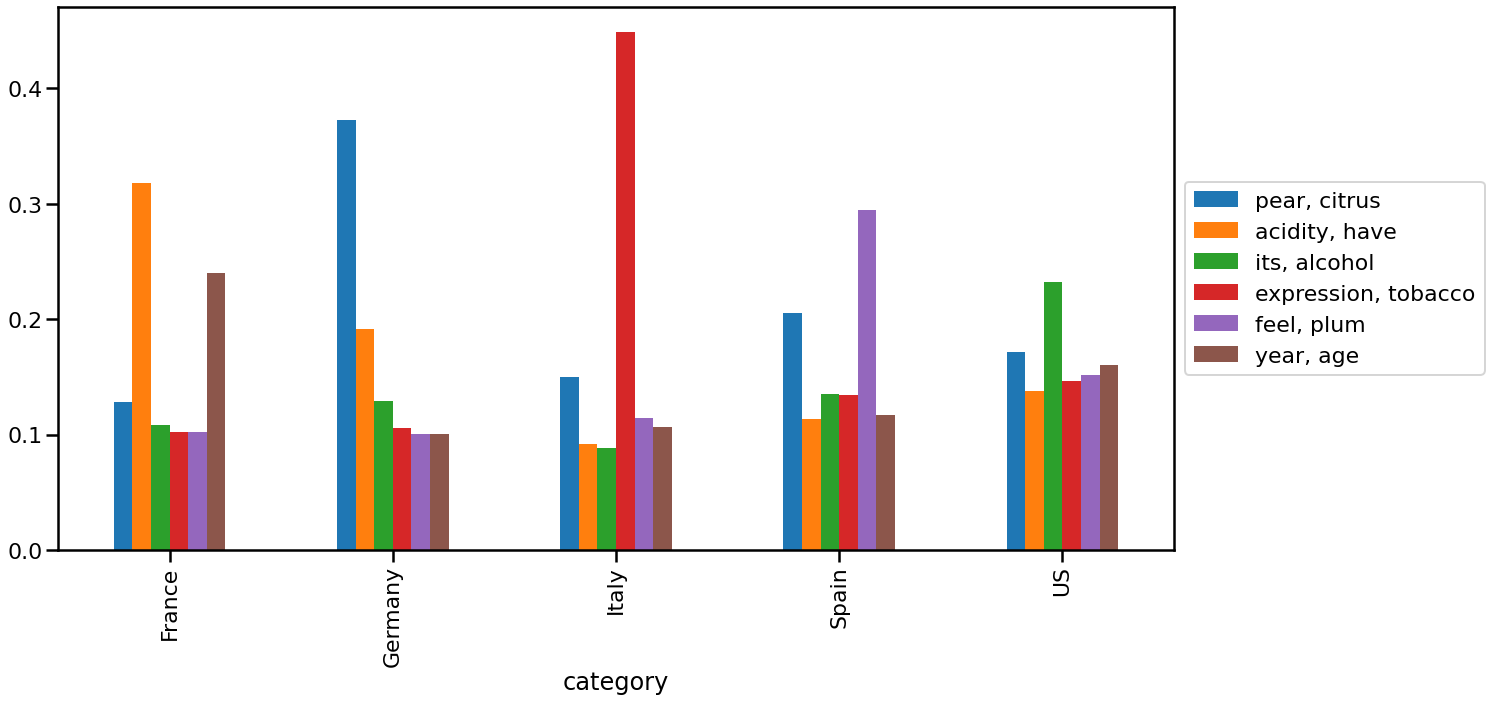

In [71]:
import matplotlib.pyplot as plt # make graphs
import seaborn # make prettier graphs

seaborn.set_context('poster') # use large font

fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Germany US Italy France Spain'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [73]:
topic_distros['predicted_topic'] = topic_distros[topic_distros.columns[:-2]].idxmax(axis=1)
topic_distros['review'] = df.description
topic_distros.head()

,"pear, citrus","acidity, have","its, alcohol","expression, tobacco","feel, plum","year, age",category,predicted_topic,review
0,0.077863,0.081156,0.269449,0.187297,0.148733,0.235503,US,"its, alcohol",This tremendous 100% varietal wine hails from ...
1,0.117276,0.125045,0.158783,0.220315,0.254300,0.124282,Spain,"feel, plum","Ripe aromas of fig, blackberry and cassis are ..."
2,0.355271,0.086255,0.205520,0.126204,0.069918,0.156831,US,"pear, citrus",Mac Watson honors the memory of a wine once ma...
3,0.073559,0.083614,0.106143,0.258269,0.220839,0.257575,US,"expression, tobacco","This spent 20 months in 30% new French oak, an..."
4,0.067574,0.114597,0.069581,0.147798,0.067748,0.532703,France,"year, age","This is the top wine from La Bégude, named aft..."


In [75]:
tobacco_df = topic_distros[topic_distros['predicted_topic'] == 'expression, tobacco']

In [78]:
for i in range(0,5):
  print(tobacco_df.review.iloc[i])
  print()

This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.

Deep, dense and pure from the opening bell, this Toro is a winner. Aromas of dark ripe black fruits are cool and moderately oaked. This feels massive on the palate but sensationally balanced. Flavors of blackberry, coffee, mocha and toasty oak finish spicy, smooth and heady. Drink this exemplary Toro through 2023.

A standout even in this terrific lineup of 2015 releases from Patricia Green, the Weber opens with a burst of cola and tobacco scents and accents. It continues, subtle and detailed, with flavors of oranges, vanilla, tea and milk chocolate discreetly threaded through ripe blackberry fruit.

Allu

# Author Topic Model

In [7]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

In [16]:
from collections import defaultdict

limit = 50000

author2doc = {}

for country in df.country.value_counts().keys():
  author2doc[country] = []

for i, country in enumerate(df.country[:limit]):
    author2doc[country].append(i)
    
len(author2doc)

37

In [19]:
from gensim.corpora import mmcorpus
corpus = mmcorpus.MmCorpus(datapath('testcorpus.mm'))

In [21]:
list(corpus)

[[(0, 1.0), (1, 1.0), (2, 1.0)],
 [(0, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0)],
 [(2, 1.0), (5, 1.0), (7, 1.0), (8, 1.0)],
 [(1, 1.0), (5, 2.0), (8, 1.0)],
 [(3, 1.0), (6, 1.0), (7, 1.0)],
 [(9, 1.0)],
 [(9, 1.0), (10, 1.0)],
 [(9, 1.0), (10, 1.0), (11, 1.0)],
 [(4, 1.0), (10, 1.0), (11, 1.0)]]

In [24]:
list(ldacorpus[:10])

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 2)],
 [(24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1)],
 [(2, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(4, 1),
  (9, 1),
  (10, 1),
  (16, 1),
  (20, 1),
  (24, 1),
  (27, 1),
  (28, 1),
  (30, 1),
  (32, 1),
  (43, 1),
  (48, 1),
  (62, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1)

In [25]:
num_topics = 5
author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=num_topics)

author_model.print_topics()

[(0,
  '0.040*"aroma" + 0.028*"berry" + 0.024*"feel" + 0.018*"plum" + 0.013*"herbal" + 0.013*"oak" + 0.012*"note" + 0.012*"nose" + 0.012*"blackberry" + 0.011*"good"'),
 (1,
  '0.039*"aroma" + 0.025*"cherry" + 0.023*"black" + 0.021*"offer" + 0.020*"spice" + 0.019*"tannin" + 0.019*"note" + 0.019*"white" + 0.015*"open" + 0.013*"berry"'),
 (2,
  '0.017*"cherry" + 0.012*"dry" + 0.011*"that" + 0.010*"sweet" + 0.010*"show" + 0.009*"oak" + 0.008*"spice" + 0.008*"good" + 0.008*"aroma" + 0.008*"acidity"'),
 (3,
  '0.044*"drink" + 0.043*"have" + 0.043*"tannin" + 0.038*"that" + 0.033*"rich" + 0.030*"year" + 0.028*"now" + 0.027*"ripe" + 0.025*"age" + 0.020*"structure"'),
 (4,
  '0.029*"acidity" + 0.024*"drink" + 0.022*"have" + 0.020*"that" + 0.020*"ripe" + 0.017*"its" + 0.014*"fresh" + 0.013*"rich" + 0.013*"crisp" + 0.011*"character"')]

In [26]:
coherence_values = []
author_model_list = []

dev_size = 10000
eval_size = 5000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(5, 10):
    author_model = AuthorTopicModel(corpus=(ldacorpus[:dev_size]), 
                                    author2doc=dev_author2doc, 
                                    id2word=dictionary, 
                                    num_topics=num_topics)
#     author_model_list.append(author_model)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -3.4689990539458875 0.3288453204671506
6 -2.3944358636935856 0.33054346557687103
7 -2.997387128740559 0.325275308537532
8 -3.105430281769636 0.30271411304257034
9 -3.4306513124313707 0.31217044901890045


In [101]:
dev_author2doc

{'Argentina': [60,
  62,
  111,
  115,
  184,
  190,
  269,
  326,
  455,
  460,
  467,
  469,
  662,
  722,
  723,
  737,
  739,
  742,
  746,
  900,
  999],
 'Australia': [61, 631, 660, 825, 987],
 'Austria': [582, 587, 588, 595],
 'Bulgaria': [30, 692, 748, 852],
 'Canada': [394, 517, 705, 714, 851],
 'Chile': [155,
  159,
  171,
  179,
  502,
  537,
  760,
  764,
  766,
  770,
  778,
  833,
  873,
  892,
  936,
  938,
  943,
  948],
 'Croatia': [676],
 'France': [4,
  13,
  18,
  33,
  36,
  44,
  51,
  52,
  53,
  56,
  63,
  66,
  76,
  86,
  95,
  98,
  99,
  117,
  118,
  139,
  140,
  156,
  174,
  191,
  192,
  193,
  194,
  195,
  202,
  203,
  214,
  215,
  218,
  219,
  222,
  225,
  235,
  236,
  237,
  240,
  241,
  242,
  243,
  244,
  261,
  265,
  270,
  271,
  282,
  283,
  286,
  287,
  288,
  290,
  294,
  318,
  320,
  322,
  325,
  327,
  328,
  352,
  363,
  364,
  368,
  369,
  370,
  373,
  396,
  404,
  405,
  427,
  434,
  466,
  476,
  482,
  484,
  485,
  

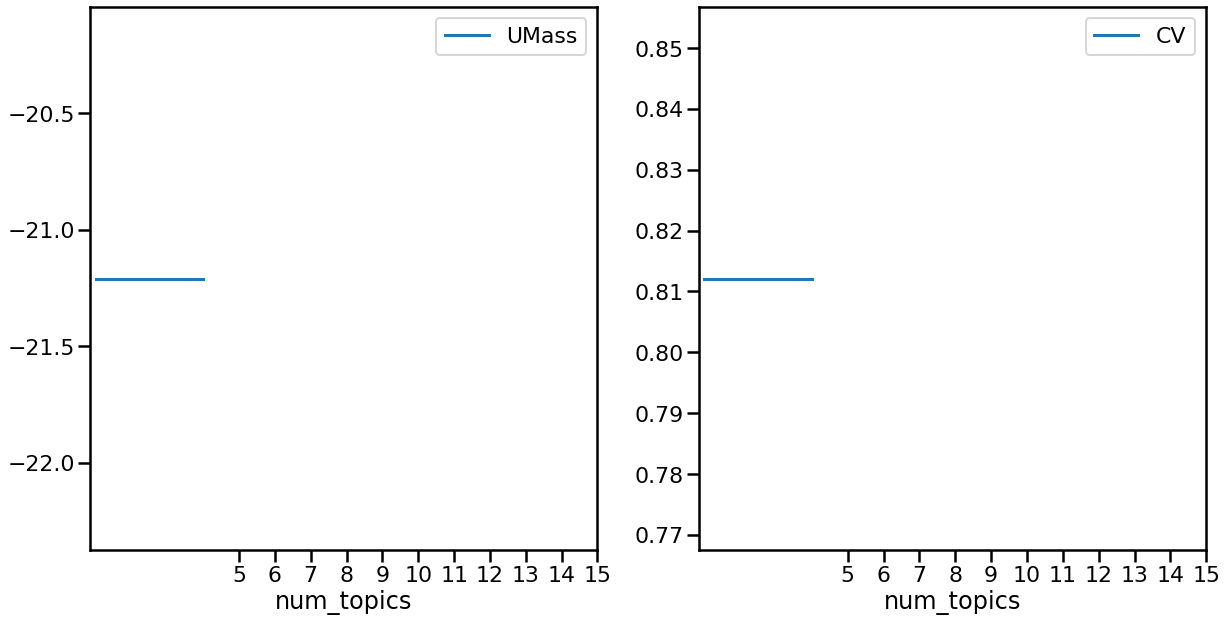

In [92]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [89]:
n_topics_author = 8


author_model = AuthorTopicModel(corpus=list(model_corpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5
)


In [90]:
# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "iron", "yet", "grippy", "stainless", "zesty"
2 "iron", "yet", "grippy", "stainless", "zesty"
3 "iron", "yet", "grippy", "stainless", "zesty"
4 "iron", "yet", "grippy", "stainless", "zesty"
5 "iron", "yet", "grippy", "stainless", "zesty"
6 "iron", "yet", "grippy", "stainless", "zesty"
7 "iron", "yet", "grippy", "stainless", "zesty"
8 "iron", "yet", "grippy", "stainless", "zesty"


In [86]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

for country in 'Germany US Italy France Spain'.split():
    print(country, author_vecs[country])        

Germany {'iron, yet': 0.125}
US {'iron, yet': 0.125}
Italy {'iron, yet': 0.125}
France {'iron, yet': 0.125}
Spain {'iron, yet': 0.125}


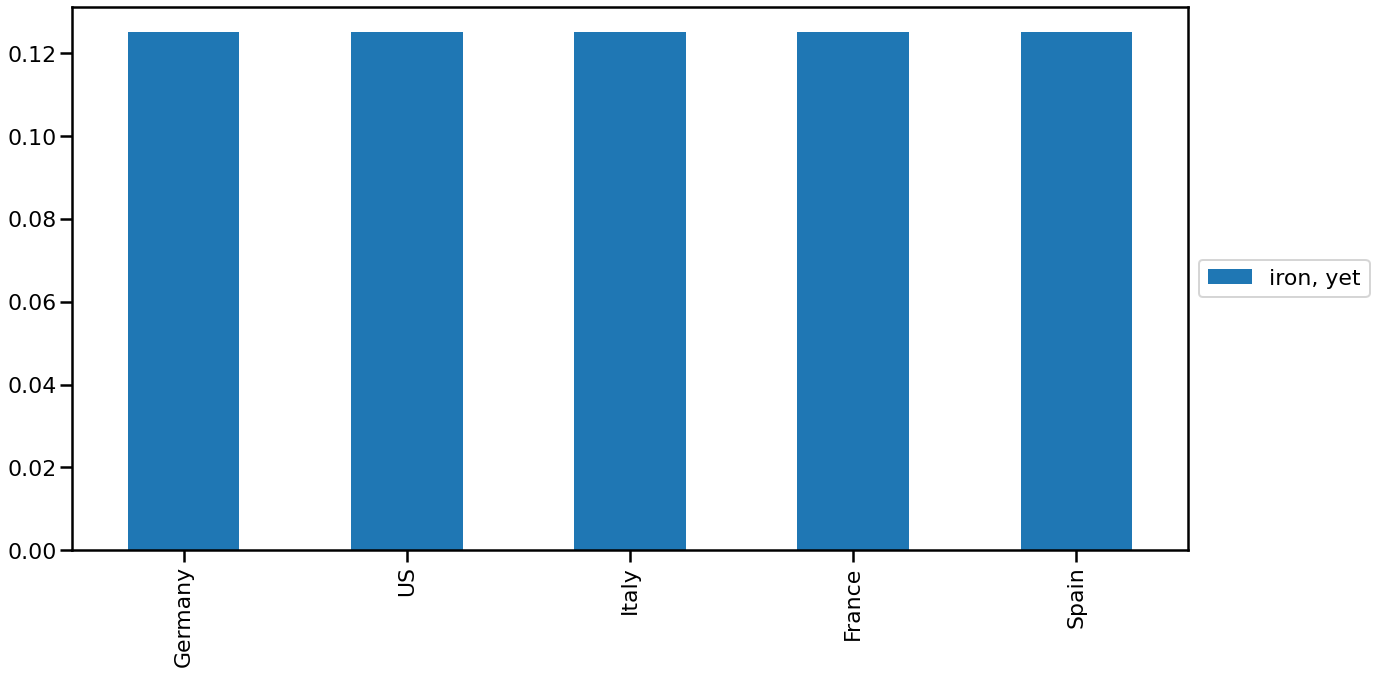

In [87]:
author_df = pd.DataFrame.from_dict(author_vecs)
fig, ax = plt.subplots(figsize=(20,10))
author_df['Germany US Italy France Spain'.split()].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));


# Guided LDA

In [98]:
! pip install guidedlda

  Using cached https://files.pythonhosted.org/packages/f8/ee/6d6e2b3525388399e12a4482554c7529a5fcf5e99c50a60abaa02894b8bf/guidedlda-2.0.0.dev22.tar.gz
  ERROR: Failed building wheel for guidedlda
  Running setup.py clean for guidedlda
Failed to build guidedlda
    Running setup.py install for guidedlda ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-tlorgvx1/guidedlda/setup.py'"'"'; __file__='"'"'/tmp/pip-install-tlorgvx1/guidedlda/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-8q7i4gi5/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [97]:
import numpy as np
import guidedlda
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorize input
vectorizer = CountVectorizer(analyzer='word', 
                             ngram_range=(1,2), 
                             min_df=100, 
                             max_df=0.3, 
                             stop_words='english')

X = vectorizer.fit_transform(df.description_cleaned[:limit].tolist())

# store lookup structures for convenience
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

print(X.shape)

ModuleNotFoundError: ignored

In [ ]:
# define topic seeds based on intuition
indicators = {
    'BRIGHT': ["fruity", "crisp", "bright"],
    'SPICE': ["licorice", "pepper", 'spice'], 
    'GREEN FRUIT': ["apple", "lemon", "citrus", "peach", "pear"],
    'DARK': ["vanilla", "smoke", "leather"],
    'RED FRUIT': ["strawberry", "raspberry", 'cherries'],
    'FOOD': ["pair", "food", "steak"],
    'FULL': ["bodied", "smoke", "medium", "vanilla"],
    'AGEING': ["age", "year", "structure"]
}

topic_names, seed_topic_list = zip(*indicators.items())
# filter out all words not actually in vocab
seed_topic_list = [[w for w in words if w in set(vocab)] for words in seed_topic_list]
    
# create a mapping {word_id: k}, which we need for the model
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
print(seed_topic_list)

In [ ]:
# define model
model = guidedlda.GuidedLDA(n_topics=len(seed_topic_list), 
                            n_iter=1000, 
                            random_state=7, 
                            refresh=50, 
                            alpha=0.5, 
                            eta=0.000001)

# fit the model with seeds
doc_topic = model.fit_transform(X, seed_topics=seed_topics, seed_confidence=10)

# retrieve the word descriptors
n_top_words = 5
topic_word = model.topic_word_
descriptors_guided = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: "{}"'.format(topic_names[i], '" "'.join(topic_words)))
    descriptors_guided.append(' '.join(topic_words[:2]))

In [ ]:
target_category = 'country'
# get a list of all the topic scores for each document
# scores = [[t[1] for t in topic_corpus[entry]] for entry in range(limit)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros_guided = pd.DataFrame(data=model.doc_topic_, columns=descriptors_guided)
# add the review category of each document (so we can aggregate)
topic_distros_guided['category'] = df[target_category][:limit]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros_guided[topic_distros_guided.category.isin('Germany US Italy France Spain'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors_guided].plot.bar(ax=ax);
# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));